<a href="https://colab.research.google.com/github/Matt1368/UMD-NN-Quadrotor-/blob/main/Quadrotor_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
class Quadrotor:
    def __init__(self, mass, length, Jxx, Jyy, Jzz, kf, kd):
        self.m = mass
        self.l = length
        self.Jxx = Jxx
        self.Jyy = Jyy
        self.Jzz = Jzz
        self.kf = kf
        self.kd = kd

    def dynamics(self, t, state, inputs):
        # State variables
        x, y, z = state[0], state[1], state[2]
        u, v, w = state[3], state[4], state[5]
        phi, theta, psi = state[6], state[7], state[8]
        p, q, r = state[9], state[10], state[11]

        # Inputs (rotor speeds)
        omega1, omega2, omega3, omega4 = inputs
        omega1_sq, omega2_sq, omega3_sq, omega4_sq = omega1**2, omega2**2, omega3**2, omega4**2

        # Thrust and torques
        F = self.kf * (omega1_sq + omega2_sq + omega3_sq + omega4_sq)
        tau_phi = self.l * self.kf * (omega4_sq - omega2_sq)
        tau_theta = self.l * self.kf * (omega3_sq - omega1_sq)
        tau_psi = self.kd * (omega1_sq - omega2_sq + omega3_sq - omega4_sq)

        # Rotation matrix from body frame to inertial frame
        R = np.array([
            [np.cos(theta) * np.cos(psi), np.cos(theta) * np.sin(psi), -np.sin(theta)],
            [np.sin(phi) * np.sin(theta) * np.cos(psi) - np.cos(phi) * np.sin(psi), np.sin(phi) * np.sin(theta) * np.sin(psi) + np.cos(phi) * np.cos(psi), np.sin(phi) * np.cos(theta)],
            [np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi), np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi), np.cos(phi) * np.cos(theta)]
        ])

        # Translational accelerations
        acc = (1 / self.m) * (R @ np.array([0, 0, F]) - np.array([0, 0, self.m * 9.81]))
        u_dot, v_dot, w_dot = acc[0], acc[1], acc[2]

        # Rotational accelerations
        p_dot = (tau_phi - (self.Jyy - self.Jzz) * q * r) / self.Jxx
        q_dot = (tau_theta - (self.Jzz - self.Jxx) * p * r) / self.Jyy
        r_dot = (tau_psi - (self.Jxx - self.Jyy) * p * q) / self.Jzz

        # Angular velocity to Euler angle rates
        phi_dot = p + q * np.sin(phi) * np.tan(theta) + r * np.cos(phi) * np.tan(theta)
        theta_dot = q * np.cos(phi) - r * np.sin(phi)
        psi_dot = q * np.sin(phi) / np.cos(theta) + r * np.cos(phi) / np.cos(theta)

        # State derivatives
        state_dot = np.array([u, v, w, u_dot, v_dot, w_dot, phi_dot, theta_dot, psi_dot, p_dot, q_dot, r_dot])

        return state_dot, acc, np.array([p_dot, q_dot, r_dot])

    def simulate_with_noise_and_disturbances(self, initial_state, inputs, t_span, t_eval):
        time = t_eval
        state = np.zeros((len(time), len(initial_state)))
        accelerations = np.zeros((len(time), 3))
        angular_accelerations = np.zeros((len(time), 3))

        state[0] = initial_state
        state_noise_std = 0.01  # Increased noise level for better visibility
        input_noise_std = 0.01  # Noise level for input disturbances

        for i in range(1, len(time)):
            t = time[i-1]
            dt = time[i] - time[i-1]

            # Add white Gaussian noise to inputs (input disturbances)
            disturbed_inputs = inputs[i-1] + np.random.normal(0, input_noise_std, size=inputs[i-1].shape)

            # Ensure no negative rotor speeds
            disturbed_inputs = np.clip(disturbed_inputs, 0, None)

            state_dot, acc, ang_acc = self.dynamics(t, state[i-1], disturbed_inputs)

            # Add white Gaussian noise to state derivatives
            state_noise = np.random.normal(0, state_noise_std, size=state_dot.shape)
            state_dot += state_noise

            state[i] = state[i-1] + state_dot * dt
            accelerations[i] = acc
            angular_accelerations[i] = ang_acc

        return time, state, accelerations, angular_accelerations

def save_to_csv(filename, time, states, accelerations, angular_accelerations, inputs):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write header
        header = ['Time [s]', 'X [m]', 'Y [m]', 'Z [m]', 'U [m/s]', 'V [m/s]', 'W [m/s]',
                  'Phi [rad]', 'Theta [rad]', 'Psi [rad]', 'P [rad/s]', 'Q [rad/s]', 'R [rad/s]',
                  'U_dot [m/s^2]', 'V_dot [m/s^2]', 'W_dot [m/s^2]',
                  'P_dot [rad/s^2]', 'Q_dot [rad/s^2]', 'R_dot [rad/s^2]',
                  'Omega1 [rpm]', 'Omega2 [rpm]', 'Omega3 [rpm]', 'Omega4 [rpm]', 'Rotor1_Failure', 'Rotor2_Failure', 'Rotor3_Failure', 'Rotor4_Failure']
        writer.writerow(header)

        # Write data
        for i in range(len(time)):
            rotor_failures = [1 if omega == 0 else 0 for omega in inputs[i]]
            row = [time[i]] + list(states[i]) + list(accelerations[i]) + list(angular_accelerations[i]) + list(inputs[i]) + rotor_failures
            writer.writerow(row)

def load_from_csv(filename):
    time = []
    states = []
    accelerations = []
    angular_accelerations = []
    inputs = []
    failures = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        header = next(reader)

        for row in reader:
            time.append(float(row[0]))
            states.append([float(x) for x in row[1:13]])
            accelerations.append([float(x) for x in row[13:16]])
            angular_accelerations.append([float(x) for x in row[16:19]])
            inputs.append([float(x) for x in row[19:23]])
            failures.append([int(x) for x in row[23:27]])

    return np.array(time), np.array(states), np.array(accelerations), np.array(angular_accelerations), np.array(inputs), np.array(failures)


In [ ]:
def plot_simulation_data(filename):
    time, states, accelerations, angular_accelerations, inputs, failures = load_from_csv(filename)

    fig, axs = plt.subplots(6, 3, figsize=(15, 20), sharex=True)

    # Position
    axs[0, 0].plot(time, states[:, 0], label='X [m]')
    axs[0, 1].plot(time, states[:, 1], label='Y [m]')
    axs[0, 2].plot(time, states[:, 2], label='Z [m]')
    axs[0, 0].set_ylabel('Position')
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[0, 2].legend()
    axs[0, 0].set_xlim(time[0], time[-1])
    axs[0, 1].set_xlim(time[0], time[-1])
    axs[0, 2].set_xlim(time[0], time[-1])
    axs[0, 0].set_ylim(np.min(states[:, :3]), np.max(states[:, :3]))
    axs[0, 1].set_ylim(np.min(states[:, :3]), np.max(states[:, :3]))
    axs[0, 2].set_ylim(np.min(states[:, :3]), np.max(states[:, :3]))

    # Linear Velocity
    axs[1, 0].plot(time, states[:, 3], label='U [m/s]')
    axs[1, 1].plot(time, states[:, 4], label='V [m/s]')
    axs[1, 2].plot(time, states[:, 5], label='W [m/s]')
    axs[1, 0].set_ylabel('Linear Velocity')
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[1, 2].legend()
    axs[1, 0].set_xlim(time[0], time[-1])
    axs[1, 1].set_xlim(time[0], time[-1])
    axs[1, 2].set_xlim(time[0], time[-1])
    axs[1, 0].set_ylim(np.min(states[:, 3:6]), np.max(states[:, 3:6]))
    axs[1, 1].set_ylim(np.min(states[:, 3:6]), np.max(states[:, 3:6]))
    axs[1, 2].set_ylim(np.min(states[:, 3:6]), np.max(states[:, 3:6]))

    # Linear Acceleration
    axs[2, 0].plot(time, accelerations[:, 0], label='U_dot [m/s^2]')
    axs[2, 1].plot(time, accelerations[:, 1], label='V_dot [m/s^2]')
    axs[2, 2].plot(time, accelerations[:, 2], label='W_dot [m/s^2]')
    axs[2, 0].set_ylabel('Linear Acceleration')
    axs[2, 0].legend()
    axs[2, 1].legend()
    axs[2, 2].legend()
    axs[2, 0].set_xlim(time[0], time[-1])
    axs[2, 1].set_xlim(time[0], time[-1])
    axs[2, 2].set_xlim(time[0], time[-1])
    axs[2, 0].set_ylim(np.min(accelerations[:, :3]), np.max(accelerations[:, :3]))
    axs[2, 1].set_ylim(np.min(accelerations[:, :3]), np.max(accelerations[:, :3]))
    axs[2, 2].set_ylim(np.min(accelerations[:, :3]), np.max(accelerations[:, :3]))

    # Orientation
    axs[3, 0].plot(time, states[:, 6], label='Phi [rad]')
    axs[3, 1].plot(time, states[:, 7], label='Theta [rad]')
    axs[3, 2].plot(time, states[:, 8], label='Psi [rad]')
    axs[3, 0].set_ylabel('Orientation')
    axs[3, 0].legend()
    axs[3, 1].legend()
    axs[3, 2].legend()
    axs[3, 0].set_xlim(time[0], time[-1])
    axs[3, 1].set_xlim(time[0], time[-1])
    axs[3, 2].set_xlim(time[0], time[-1])
    axs[3, 0].set_ylim(np.min(states[:, 6:9]), np.max(states[:, 6:9]))
    axs[3, 1].set_ylim(np.min(states[:, 6:9]), np.max(states[:, 6:9]))
    axs[3, 2].set_ylim(np.min(states[:, 6:9]), np.max(states[:, 6:9]))

    # Angular Velocity
    axs[4, 0].plot(time, states[:, 9], label='P [rad/s]')
    axs[4, 1].plot(time, states[:, 10], label='Q [rad/s]')
    axs[4, 2].plot(time, states[:, 11], label='R [rad/s]')
    axs[4, 0].set_ylabel('Angular Velocity')
    axs[4, 0].legend()
    axs[4, 1].legend()
    axs[4, 2].legend()
    axs[4, 0].set_xlim(time[0], time[-1])
    axs[4, 1].set_xlim(time[0], time[-1])
    axs[4, 2].set_xlim(time[0], time[-1])
    axs[4, 0].set_ylim(np.min(states[:, 9:12]), np.max(states[:, 9:12]))
    axs[4, 1].set_ylim(np.min(states[:, 9:12]), np.max(states[:, 9:12]))
    axs[4, 2].set_ylim(np.min(states[:, 9:12]), np.max(states[:, 9:12]))

    # Angular Acceleration
    axs[5, 0].plot(time, angular_accelerations[:, 0], label='P_dot [rad/s^2]')
    axs[5, 1].plot(time, angular_accelerations[:, 1], label='Q_dot [rad/s^2]')
    axs[5, 2].plot(time, angular_accelerations[:, 2], label='R_dot [rad/s^2]')
    axs[5, 0].set_ylabel('Angular Acceleration')
    axs[5, 0].set_xlabel('Time [s]')
    axs[5, 0].legend()
    axs[5, 1].legend()
    axs[5, 2].legend()
    axs[5, 0].set_xlim(time[0], time[-1])
    axs[5, 1].set_xlim(time[0], time[-1])
    axs[5, 2].set_xlim(time[0], time[-1])
    axs[5, 0].set_ylim(np.min(angular_accelerations[:, :3]), np.max(angular_accelerations[:, :3]))
    axs[5, 1].set_ylim(np.min(angular_accelerations[:, :3]), np.max(angular_accelerations[:, :3]))
    axs[5, 2].set_ylim(np.min(angular_accelerations[:, :3]), np.max(angular_accelerations[:, :3]))

    plt.tight_layout()
    plt.show()

def plot_3d_trajectory(filename):
    time, states, accelerations, angular_accelerations, inputs, failures = load_from_csv(filename)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(states[:, 0], states[:, 1], states[:, 2], label='Quadrotor Trajectory')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.legend()

    plt.show()

def save_3d_animation(filename, output_video):
    time, states, accelerations, angular_accelerations, inputs, failures = load_from_csv(filename)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(np.min(states[:, 0]), np.max(states[:, 0]))
    ax.set_ylim(np.min(states[:, 1]), np.max(states[:, 1]))
    ax.set_zlim(np.min(states[:, 2]), np.max(states[:, 2]))
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')

    line, = ax.plot([], [], [], lw=2)

    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        return line,

    def animate(i):
        line.set_data(states[:i, 0], states[:i, 1])
        line.set_3d_properties(states[:i, 2])
        return line,

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(time), interval=20, blit=True)

    ani.save(output_video, writer='ffmpeg')
    plt.show()


Parameters Document: https://www.researchgate.net/figure/Considered-physical-parameters-of-the-Crazyflie-21_tbl1_364025711

<ipython-input-3-bb593380012d>:40: RuntimeWarning: overflow encountered in scalar divide
  p_dot = (tau_phi - (self.Jyy - self.Jzz) * q * r) / self.Jxx
<ipython-input-3-bb593380012d>:41: RuntimeWarning: overflow encountered in scalar divide
  q_dot = (tau_theta - (self.Jzz - self.Jxx) * p * r) / self.Jyy
<ipython-input-3-bb593380012d>:42: RuntimeWarning: invalid value encountered in scalar multiply
  r_dot = (tau_psi - (self.Jxx - self.Jyy) * p * q) / self.Jzz
<ipython-input-3-bb593380012d>:80: RuntimeWarning: invalid value encountered in add
  state[i] = state[i-1] + state_dot * dt
<ipython-input-3-bb593380012d>:30: RuntimeWarning: invalid value encountered in cos
  [np.cos(theta) * np.cos(psi), np.cos(theta) * np.sin(psi), -np.sin(theta)],
<ipython-input-3-bb593380012d>:30: RuntimeWarning: invalid value encountered in sin
  [np.cos(theta) * np.cos(psi), np.cos(theta) * np.sin(psi), -np.sin(theta)],
<ipython-input-3-bb593380012d>:31: RuntimeWarning: invalid value encountered in sin
  

Simulation data saved to quadrotor_simulation_data_onethreeval.csv


ValueError: Axis limits cannot be NaN or Inf

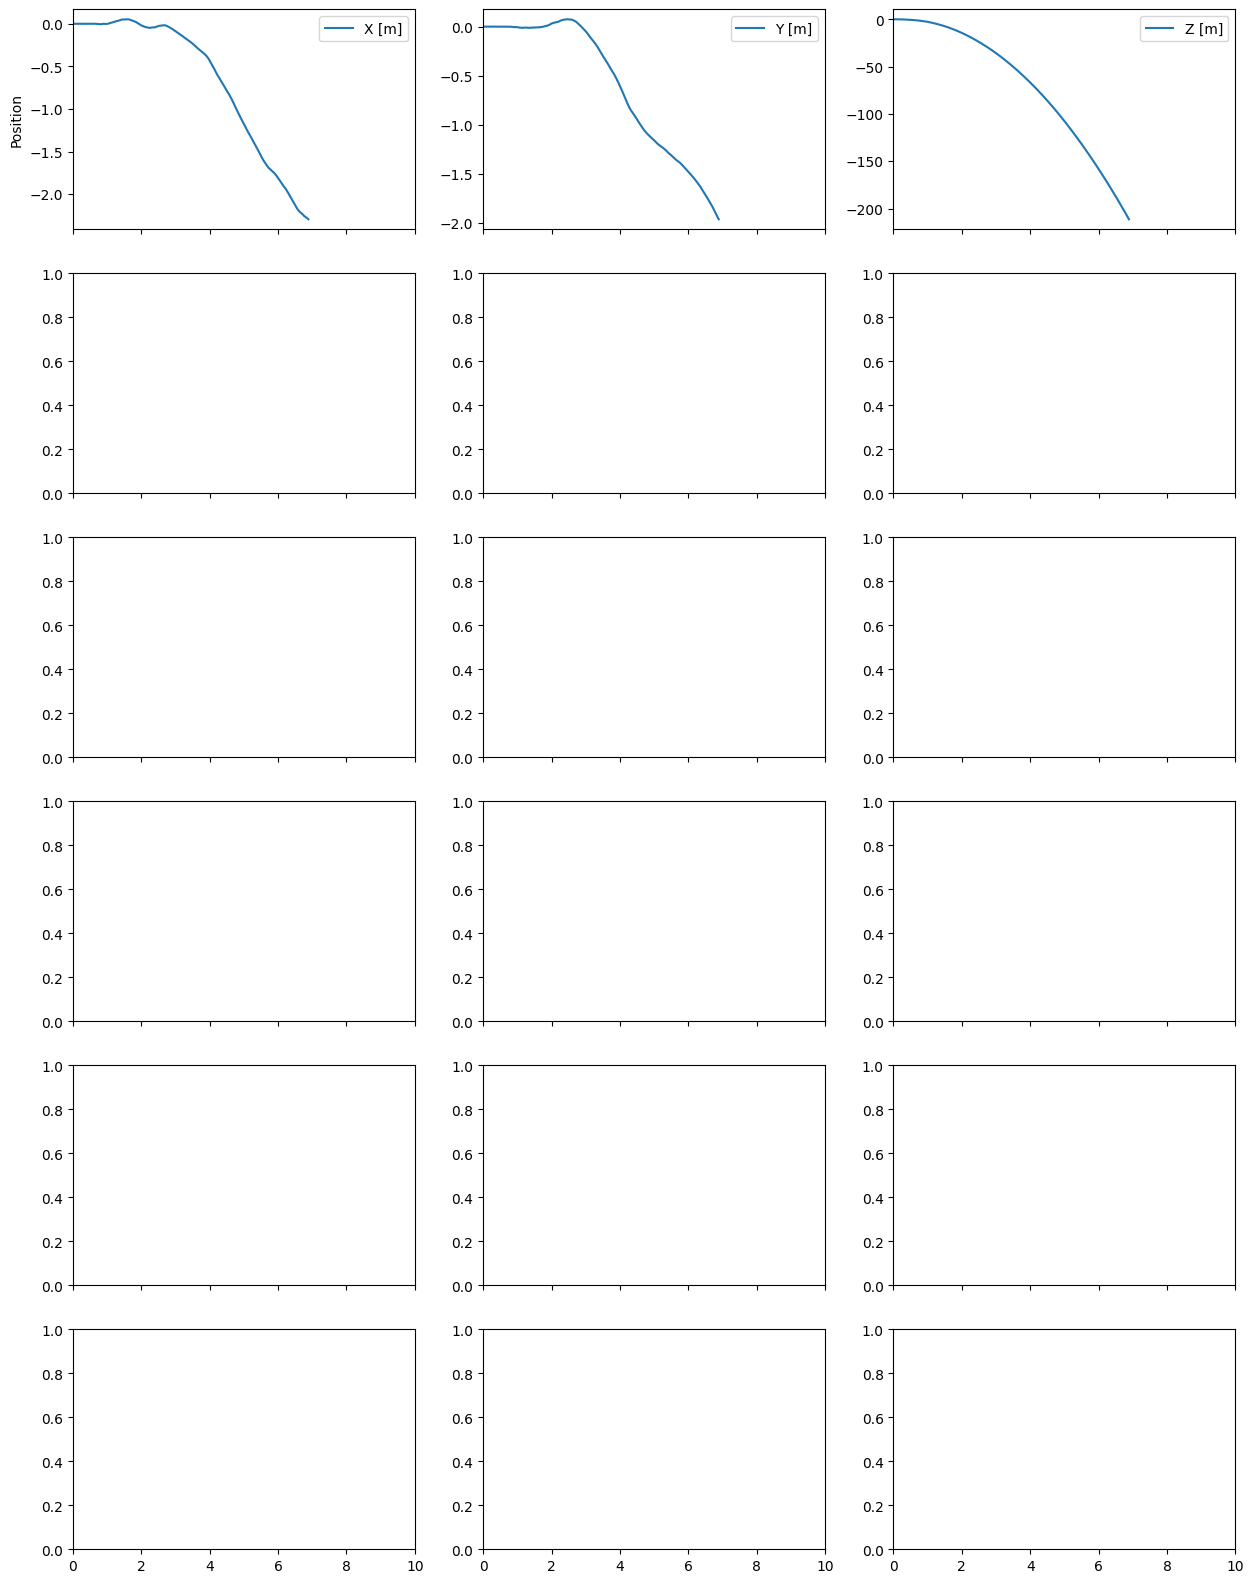

In [ ]:
# Define quadrotor parameters
mass = 0.028       # kg
length = 0.092     # meters (propeller to propeller length)
Jxx = 0.000014     # kg.m^2
Jyy = 0.000014     # kg.m^2
Jzz = 0.0000217    # kg.m^2
kf = 0.0000000288  # N/(rad/s)^2
kd = 0.000000000724 # Nm/(rad/s)^2 (drag coefficient)

quadrotor = Quadrotor(mass, length, Jxx, Jyy, Jzz, kf, kd)

# Define initial state and inputs
initial_state = np.zeros(12)  # Start from rest

# Rotor speeds (inputs)
inputs = np.tile([0, 1545, 0, 1545], (1000, 1))
failure_indices = np.random.choice(1000, size=1000, replace=False)
inputs[failure_indices, 2] = 0  # Simulate rotor failure

# Time span for the simulation
t_span = (0, 3)
t_eval = np.linspace(0, 3, 300)

# Run the simulation with noise and input disturbances
time, states, accelerations, angular_accelerations = quadrotor.simulate_with_noise_and_disturbances(initial_state, inputs, t_span, t_eval)

# Save data to CSV
filename = 'quadrotor_simulation_data_onethreeval.csv'
save_to_csv(filename, time, states, accelerations, angular_accelerations, inputs)

print(f"Simulation data saved to {filename}")

# Plot simulation data
plot_simulation_data(filename)

# Plot 3D trajectory
plot_3d_trajectory(filename)

# Save 3D animation to an MP4 video file
output_video = 'quadrotor_trajectory.mp4'
save_3d_animation(filename, output_video)
print(f"3D animation saved to {output_video}")